In [1]:
#hide
#skip
! [ -e /content ] && pip install -Uqq self-supervised

# DINO ImageWang Tutorial

**Note:** This notebook demonstrates how to use `DINO` callback with a single GPU.

First import **fastai** for training and other helpers, you can choose not to use **wandb** by setting `WANDB=False`.

In [2]:
from fastai.vision.all import *
torch.backends.cudnn.benchmark = True
WANDB = False
if WANDB:
    try:
        from fastai.callback.wandb import WandbCallback
        import wandb
    except:
        raise ImportError("Please run '!pip install wandb' on another cell to install wandb")

Then import **self_supervised** `augmentations` module for creating augmentations pipeline, `layers` module for creating encoder and model, and finally `simclr` for self-supervised training.

In [3]:
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.models.vision_transformer import *
from self_supervised.vision.dino import *
from self_supervised.vision.swav import get_swav_aug_pipelines

In this notebook we will take a look at [ImageWang](https://github.com/fastai/imagenette#image%E7%BD%91) benchmark, how to train a self-supervised model using MoCo algorithm and then how to use this pretrained model for finetuning on the given downstream task. 

## Pretraining

In [4]:
def get_dls(size, bs, workers=None, n_subset=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    if n_subset is None: files = get_image_files(source)
    else:              files = np.random.choice(get_image_files(source), n_subset)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

ImageWang has several benchmarks for different image sizes, in this tutorial we will go for `size=224` and also demonstrate how effectively you can utilize GPU memory.

Define batch size, resize resolution before batching and size for random cropping during self-supervised training. It's always good to use a batch size as high as it can fit the GPU memory.

In [5]:
bs, resize, size = 64, 256, 224

Let's create a ViT DINO model.

In [6]:
deits16 = deit_small(patch_size=16, drop_path_rate=0.1)
deits16 = MultiCropWrapper(deits16)
dino_head = DINOHead(deits16.encoder.embed_dim, 2**16, norm_last_layer=True)
student_model = nn.Sequential(deits16,dino_head)

deits16 = deit_small(patch_size=16)
deits16 = MultiCropWrapper(deits16)
dino_head = DINOHead(deits16.encoder.embed_dim, 2**16, norm_last_layer=True)
teacher_model = nn.Sequential(deits16,dino_head)

dino_model = DINOModel(student_model, teacher_model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [7]:
if WANDB:
    xtra_config = {"Arch":"deits16", "Resize":resize, "Size":size, "Algorithm":"DINO"}
    wandb.init(project="self-supervised-imagewang", config=xtra_config);

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: keremturgutlu (use `wandb login --relogin` to force relogin)


Initialize the Dataloaders using the function above.

In [8]:
dls = get_dls(resize, bs, n_subset=None)

Next step is perhaps the most critical step for achieving good results on a custom problem - data augmentation. For this, we will use utility function from `self_supervised.vision.simclr.get_simclr_aug_pipelines` but you can also use your own list of Pipeline augmentations. `self_supervised.vision.simclr.get_moco_aug_pipelines`should be enough for most of the cases since under the hood it uses `self_supervised.augmentations.get_multi_aug_pipelines` and `self_supervised.augmentations.get_batch_augs`. You can do shift+tab and see all the arguments that can be passed to `get_simclr_aug_pipelines`. You can simply pass anything that you could pass to `get_batch_augs` including custom `xtra_tfms`.

`get_simclr_aug_pipelines` excepts size for random resized cropping of the 2 views of a given image and the rest of the arguments are coming from `get_batch_augs()`

In [9]:
aug_pipelines = get_dino_aug_pipelines(rotate=True, 
                                       rotate_deg=10, 
                                       jitter=True, 
                                       bw=True, 
                                       blur=True,
                                       blur_s=(4, 16))

# aug_pipelines = get_swav_aug_pipelines(num_crops=[2,6],
#                                        crop_sizes=[224,96], 
#                                        min_scales=[0.25,0.2],
#                                        max_scales=[1.0,0.35],
#                                        rotate=True, rotate_deg=10, jitter=True, bw=True, blur=False) 

In [10]:
# aug_pipelines

Here, we will feed the augmentation pipelines and leave temperature parameter as default.

In [11]:
class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end."
    _only_train_loop,order = True,TrackerCallback.order+1
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, at_end=False,
                 with_opt=False, reset_on_fit=True):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
        # keep track of file path for loggers
        self.last_saved_path = None
        store_attr('fname,every_epoch,at_end,with_opt')

    def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        if self.every_epoch:
            if (self.epoch%self.every_epoch) == 0: self._save(f'{self.fname}_{self.epoch}')
        else: #every improvement
            super().after_epoch()
            if self.new_best:
                print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                self._save(f'{self.fname}')

    def after_fit(self, **kwargs):
        "Load the best model."
        if self.at_end: self._save(f'{self.fname}')
        elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)

In [12]:
dino_cb = DINO(aug_pipelines=aug_pipelines,
               tpt_start=0.04,
               tpt_end=0.04,
               tpt_warmup_pct=0., 
               freeze_last_layer=1)

In [13]:
grad_clip_cb = GradientClip(max_norm=3., norm_type=2.)
save_cb = SaveModelCallback(every_epoch=20, with_opt=True, fname='dino_pretraining')
nan_cb = TerminateOnNaNCallback()

cbs=[dino_cb, grad_clip_cb, save_cb, nan_cb]

In [14]:
if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]

In [15]:
learn = Learner(dls, dino_model, opt_func=Adam, cbs=cbs)

In [16]:
learn.to_fp16();

Before starting training let's check whether our augmentations makes sense or not. Since this step consumes GPU memory, once you are done with inspection, restart the notebook and skip this step. We can see that 2 views of the same image side by side and indeed augmentations look pretty good. Now, it's time restart the notebook and skip this step.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


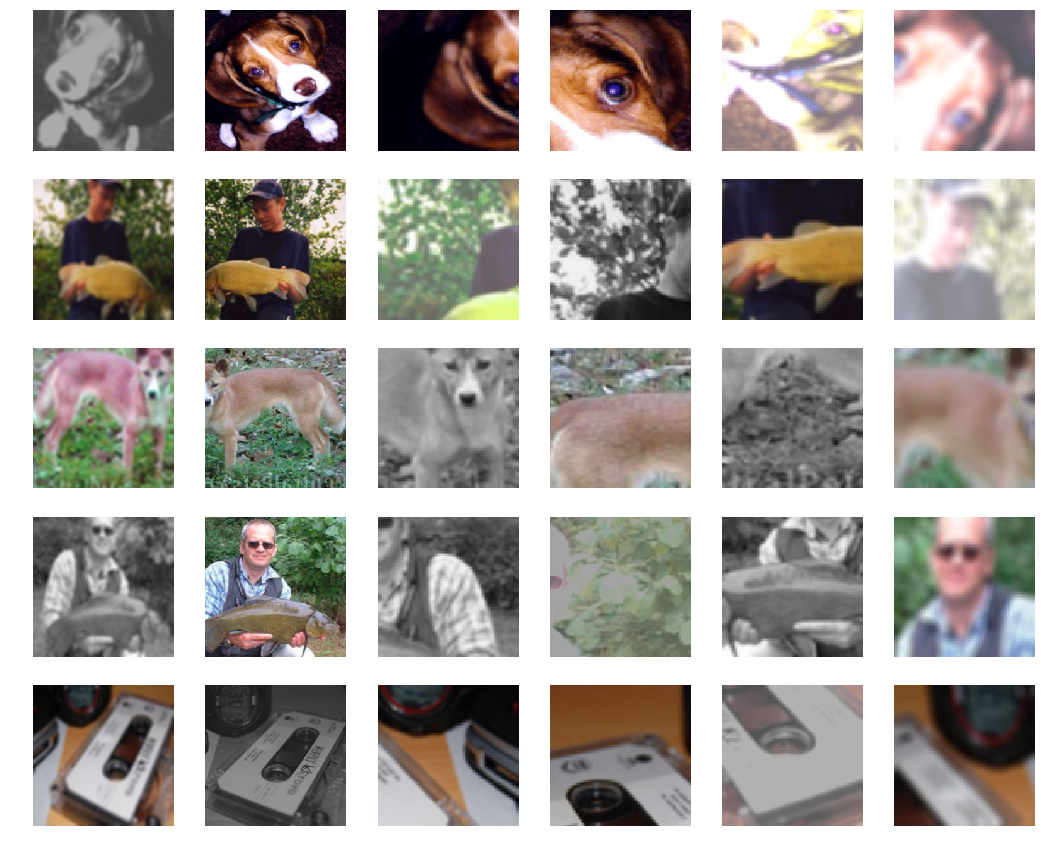

In [15]:
b = dls.one_batch()
learn._split(b)
learn('before_fit')
learn('before_batch')
learn.dino.show(n=5);

Use mixed precision with `to_fp16()` for more GPU memory, larger batch size and faster training . We could also use gradient checkpointing wrapper models from `self_supervised.layers` to save even more memory, e.g. `CheckpointSequential()`.

In [16]:
# learn.lr_find()

Learning good representations via contrastive learning usually takes a lot of epochs. So here number epochs are set to 100. This might change depending on your data distribution and dataset size.

In [ ]:
max_lr = 2.5e-4
lr_sched = combine_scheds([0.1,0.9], [SchedLin(0.,max_lr), SchedCos(max_lr,1e-6)])
wd_sched = SchedCos(0.04,0.4)
param_scheduler = ParamScheduler({"lr":lr_sched, "wd":wd_sched})
learn.fit(200, cbs=[param_scheduler])

epoch,train_loss,valid_loss,time
0,10.905972,10.884517,04:21
1,10.799708,10.744269,04:21
2,10.395583,10.386750,04:20
3,10.667659,10.673615,04:22
4,10.524393,10.505392,04:22
5,10.400627,10.372112,04:22
6,10.272190,10.226895,04:22
7,10.106242,10.131449,04:22
8,10.017877,9.977060,04:22
9,9.887113,9.915744,04:22


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Setting last layer to trainable


In [ ]:
if WANDB: wandb.finish()

## Downstream Task

In [8]:
# downstream training with pretrained model using the original repo code
# class MultiCropWrapper(nn.Module):
#     """
#     Perform forward pass separately on each resolution input.
#     The inputs corresponding to a single resolution are clubbed and single
#     forward is run on the same resolution inputs. Hence we do several
#     forward passes = number of different resolutions used. We then
#     concatenate all the output features and run the head forward on these
#     concatenated features.
#     """
#     def __init__(self, backbone, head):
#         super(MultiCropWrapper, self).__init__()
#         # disable layers dedicated to ImageNet labels classification
#         backbone.fc, backbone.head = nn.Identity(), nn.Identity()
#         self.backbone = backbone
#         self.head = head

#     def forward(self, x):
#         # convert to list
#         if not isinstance(x, list):
#             x = [x]
#         idx_crops = torch.cumsum(torch.unique_consecutive(
#             torch.tensor([inp.shape[-1] for inp in x]),
#             return_counts=True,
#         )[1], 0)
#         start_idx = 0
#         for end_idx in idx_crops:
#             _out = self.backbone(torch.cat(x[start_idx: end_idx]))
#             if start_idx == 0:
#                 output = _out
#             else:
#                 output = torch.cat((output, _out))
#             start_idx = end_idx
#         # Run the head forward on the concatenated features.
#         return self.head(output)

# state_dict = torch.load("/home/code-base/extra_space/dino/checkpoint.pth")
# student = deit_small(patch_size=16, drop_path_rate=0.1)
# student = MultiCropWrapper(student, DINOHead(student.embed_dim, 2**16, norm_last_layer=True))
# student_dict = OrderedDict({".".join(k.split(".")[1:]):v for k,v in state_dict['student'].items()})
# student.load_state_dict(student_dict)

# student = deit_small(patch_size=16, drop_path_rate=0.1)
# state_dict = torch.load("./models/model_99.pth")
# for n,p in student.named_parameters(): p.data = state_dict[f'0.encoder.{n}']

In [6]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [18]:
class Classifier(Module):
    def __init__(self, vit_backbone, n_feat_layers, n_classes, lin_f=1024, lin_drop=0.3, pooling='avg'):
        self.vit_backbone  = vit_backbone
        self.n_feat_layers = n_feat_layers 
        self.pooling = pooling
        out_dim = self.vit_backbone.norm.weight.size(0)
        
        if self.n_feat_layers == 1: in_f = 2*out_dim
        else:
            if pooling == 'avg':   in_f = out_dim
            elif pooling == 'cat': in_f = out_dim*n_feat_layers
        
        self.mlp = create_cls_module(in_f, n_classes)
        
    def forward(self,x):
        
        out = self.vit_backbone.get_intermediate_layers(x,self.n_feat_layers)
        
        if self.n_feat_layers == 1:
            # cat [CLS] token and avgpooled output tokens from the last layer
            cls_token, output_tokens = out[0][:,0],out[0][:,1:]
            x = torch.cat([cls_token, output_tokens.mean(1)], dim=1)
        else:
            # avgpool or cat [CLS] tokens from last n layers
            out = [o[:,0] for o in out] 
            if self.pooling == 'avg':   x = torch.stack(out,dim=0).mean(0)
            elif self.pooling == 'cat': x = torch.cat(out, 1)
            else:                       raise Exception("Pooling should be avg or cat")
                
        return self.mlp(x)

In [19]:
x = torch.randn(4,3,224,224).cuda()

In [20]:
cls_model = Classifier(student, n_feat_layers=1, n_classes=10).cuda()

In [21]:
cls_model(x).shape

torch.Size([4, 10])

In [22]:
optdict = dict(sqr_mom=0.99,mom=0.95,beta=0.,eps=1e-4)
opt_func = partial(ranger, **optdict)
bs, resize, size = 64, 256, 224

In [23]:
dls = get_dls(size, bs=bs//2)
cls_model = Classifier(student, n_feat_layers=1, n_classes=dls.c)
learn = Learner(dls, cls_model, opt_func=opt_func, metrics=[accuracy,top_k_accuracy],
                loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=0.0012022644514217973)

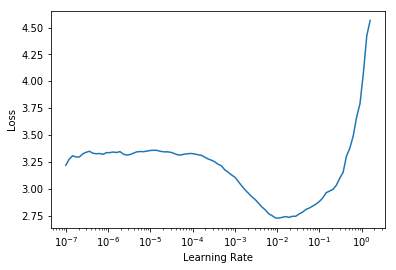

In [24]:
learn.lr_find()

In [25]:
def finetune(learn, epochs, lr=1e-3, wd=1e-2):
    learn.unfreeze()
    learn.fit_flat_cos(epochs, lr, wd=wd)
    final_acc = learn.recorder.values[-1][-2]
    return final_acc

### 5 epochs

When training with all layers trainable model underperforms very bad, which is different than than the resnet pretrained models which perform pretty good e.g. [SWAV XResNet34](https://github.com/KeremTurgutlu/self_supervised/blob/853d95aaed40c96a1870c6391495e477044b4659/examples/vision/04%20-%20training_swav_iwang.ipynb). In contrast, when fully frozen DEIT+DINO performs decent on the downstream task. This might be related to ViT characteristics and/or easy overfitting.

In [77]:
state = torch.load("./models/dino_pretraining_180.pth")

student = deit_small(patch_size=16, drop_path_rate=0.1)
student_dict = {}
for k in state['model']:
    if 'student' in k:
        student_dict[".".join(k.split(".")[3:])] = state['model'][k]
student.load_state_dict(student_dict,strict=False) # strict=False ignore MLP head

_IncompatibleKeys(missing_keys=[], unexpected_keys=['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', 'weight_g', 'weight_v'])

In [78]:
optdict = dict(sqr_mom=0.99,mom=0.95,beta=0.,eps=1e-4)
opt_func = partial(ranger, **optdict)

In [79]:
dls = get_dls(size, bs=96)
# cls_model = Classifier(student, n_feat_layers=1, n_classes=dls.c)
# cls_model = Classifier(student, n_feat_layers=2, n_classes=dls.c)
cls_model = Classifier(student, n_feat_layers=2, n_classes=dls.c, pooling='cat')

In [80]:
def model_split(model):
    groups = L([model.vit_backbone, model.mlp])
    return groups.map(params)

In [81]:
learn = Learner(dls, cls_model, opt_func=opt_func, metrics=[accuracy,top_k_accuracy], splitter=model_split,
                loss_func=LabelSmoothingCrossEntropyFlat())

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.00363078061491251)

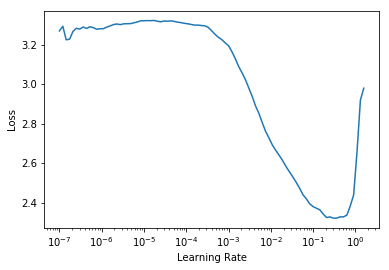

In [82]:
learn.freeze();
learn.lr_find()

In [83]:
learn.freeze();
learn.fit_flat_cos(3,1e-2,wd=1e-2)
learn.unfreeze();
learn.fit_flat_cos(2,slice(1e-4,1e-3),wd=1e-2)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.173379,2.006262,0.444897,0.875795,00:58
1,1.131220,2.043696,0.443115,0.881140,00:58
2,1.067292,1.727473,0.568592,0.903792,00:58


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.995551,1.671715,0.579537,0.923136,01:08
1,0.963949,1.623196,0.603716,0.925426,01:07


### fin